In [36]:
# ACKNOWLEDGEMENT: highly adpated from martinarjovsky/WassersteinGAN!

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.init
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import seaborn as sns
from torch.autograd import Variable
import Model.mlp as mlp
import Model.dcgan as dcgan

In [37]:
workers=4
batchSize=64
imageSize=32
nc=1
nz=100            # size of the latent z vector
ngh=128          # size of hidden layer of G
ndh=128           # size of hidden layer of D 
nker=16
kerdim=4
niter=25          # number of epochs to train for
lrD=0.00005       # learning rate for Critic, default=0.00005
lrG=0.00005      # learning rate for Generator, default=0.00005
cuda=True         # enables cuda
ngpu=6            # number of GPUs to use 
clamp_lower=-0.02
clamp_upper=0.02
diters=5        # number of D iters per each G iter
before_gen=25     # D "burn in part" 
mlp_G=True
mlp_D=True
CNN=True
n_extra_layers=0
noBN=True         # disable the batch norm
dirname="experiment"
dataroot="MNIST"
dropout=True
randomseed=10000

In [38]:
def mask_map(nz, labels=torch.LongTensor(np.random.randint(10, size=(64,1))), c=10, size=10, p=0.5):
    e = torch.eye(c)[labels.long().squeeze()]
    mask_before = torch.cat([e] * size, 1)
    if(nz - c*size > 0):
        mask_after = torch.FloatTensor(labels.size(0), nz - c * size).bernoulli_(p)
        return torch.cat([mask_before, mask_after], 1).view(-1,nz,1,1)
    else:
        return mask_before.view(-1,nz,1,1)

os.system('mkdir {0}'.format(dirname))
print("Random Seed: ", randomseed)
random.seed(randomseed)
torch.manual_seed(randomseed)

cudnn.benchmark = True


if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")
dataset = dset.MNIST(root=dataroot, download=False,
                           transform=transforms.Compose([
                               transforms.Scale(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                     ])
        )
print(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=workers)

Random Seed:  10000


In [39]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #m.weight.data.normal_(0.0, clamp_upper-clamp_lower)
        nn.init.xavier_uniform(m.weight)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        nn.init.xavier_uniform(m.weight)
if CNN:
    if dropout:
        netG=dcgan.DCGAN_G_drop(imageSize, nz, nc, ngh, ngpu, n_extra_layers, False)
    else:
        netG=dcgan.DCGAN_G(imageSize, nz, nc, ngh, ngpu, n_extra_layers, False)
    netG.apply(weights_init)
    print(netG)
    if dropout:
        netD=dcgan.DCGAN_D_drop(imageSize, nz, nc, ndh, ngpu, n_extra_layers)
    else:
        netD=dcgan.DCGAN_D(imageSize, nz, nc, ndh, ngpu, n_extra_layers)
    netD.apply(weights_init)
    print(netD)
else: 
    netG = mlp.MLP_G(imageSize, nc, nz, ngh, ngpu)
    netG.apply(weights_init)
    print(netG)

    netD = mlp.MLP_D(imageSize, nc, ndh, ngpu)
    netD.apply(weights_init)
    print(netD)

DCGAN_G_drop (
  (main): Sequential (
    (initial.100-512.convt): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial.512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (initial.512.relu): ReLU (inplace)
    (pyramid.512-256.convt): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.256.relu): ReLU (inplace)
    (pyramid.256-128.convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.128.relu): ReLU (inplace)
    (final.128-1.convt): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (final.1.tanh): Tanh ()
  )
)
DCGAN_D_drop (
  (main): Sequential (
    (initial.conv.1-128): Conv2d(1, 128, kernel_size=(4, 4), stride=(2,

In [40]:
input_x = torch.FloatTensor(batchSize, nc, imageSize, imageSize)
mask_x = torch.FloatTensor(batchSize, nz, 1, 1)

input_z = torch.ones(batchSize, 1).mm(torch.FloatTensor(1, nz).normal_(0,1)).view(batchSize, nz, 1, 1)
fixed_z = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
mask_z = torch.FloatTensor(batchSize, nz, 1, 1).copy_(mask_map(nz))
fixed_mask = torch.FloatTensor(batchSize, nz, 1, 1).copy_(mask_map(nz))

one = torch.FloatTensor([1.0])
mone = one * -1


if cuda:
    netD.cuda()
    netG.cuda()
    input_x, mask_x = input_x.cuda(), mask_x.cuda()
    one, mone = one.cuda(), mone.cuda()
    input_z, fixed_z = input_z.cuda(), fixed_z.cuda()
    mask_z, fixed_mask = mask_z.cuda(), fixed_mask.cuda()
    

optimizerD = optim.RMSprop(netD.parameters(), lr = lrD)
optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

In [41]:
gen_iterations = 0
LossD = []
for epoch in range(niter):
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        ############################
        # (1) Update D network
        ############################
        for p in netD.parameters():      # reset requires_grad
            p.requires_grad = True       # they are set to False below in netG update
            # train the discriminator Diters times
        if gen_iterations < before_gen or gen_iterations % 300 == 0:
            Diters = 100
        else:
            Diters = diters
        j = 0
        while j < Diters and i < len(dataloader):
            j += 1
            # clamp parameters to a cube
            for p in netD.parameters():
                pass
                p.data.clamp_(clamp_lower, clamp_upper)
            data = data_iter.next()
            i += 1
            # train with real
            real_cpu, real_mask = data
            netD.zero_grad()
            batch_size = real_cpu.size(0)
            error_mask = (real_mask + np.random.randint(1,9)) % 10
            if cuda:
                real_cpu = real_cpu.cuda()
                real_mask = mask_map(nz, real_mask).cuda()
                error_mask = mask_map(nz, error_mask).cuda()
            input_x.resize_as_(real_cpu).copy_(real_cpu)
            mask_x.resize_as_(real_mask).copy_(real_mask)
            inputv = Variable(input_x)
            maskv= Variable(mask_x)
            # RMSprop minimize errD_real - errD_fake, but due to equation here(https://cloud.githubusercontent.com/assets/5272722/22793339/9210a6ea-eebd-11e6-8f3d-aeae2827b955.png)
            # it maximize W estimate simultaneously, which is -Loss_D.  
            errD_real = netD(inputv, maskv)
            errD_real.backward(one)
            mask_x.resize_as_(error_mask).copy_(error_mask)
            maskv= Variable(mask_x)
            errD_real_2 = netD(inputv, maskv)
            errD_real_2.backward(mone)
            # train with fake
            if dropout:
                input_z.resize_(batchSize, nz, 1, 1).normal_(0,1)
                mask_z.resize_(batchSize, nz, 1, 1).copy_(mask_map(nz))
                input_zv = Variable(input_z, volatile = True) # totally freeze netG
                mask_zv = Variable(mask_z)
            else:
                input_z.resize_(batchSize, nz,1,1).normal_(0, 1)
                input_zv = Variable(input_z, volatile = True) # totally freeze netG
            fake = Variable(netG(input_zv, mask_zv).data)                
            inputv = fake
            errD_fake = netD(inputv, mask_zv)
            errD_fake.backward(mone)
            
            errD = errD_real - errD_fake
            optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        if dropout:
            input_z.resize_(batchSize, nz, 1, 1).normal_(0,1)
            mask_z.resize_(batchSize, nz, 1, 1).copy_(mask_map(nz))
            input_zv = Variable(input_z)
            mask_zv = Variable(mask_z)
        else:
            input_z.resize_(batchSize, nz,1,1).normal_(0, 1)
            input_zv = Variable(input_z)
        fake = netG(input_zv, mask_zv)
        errG = netD(fake, mask_zv)
        errG.backward(one)
        optimizerG.step()
        gen_iterations += 1
        print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake: %f'
            % (epoch, niter, i, len(dataloader), gen_iterations,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
        if gen_iterations % 500 == 0:
            real_cpu = real_cpu.mul(0.5).add(0.5)
            vutils.save_image(real_cpu, '{0}/real_samples.png'.format(dirname))
            fake = netG(Variable(fixed_z, volatile=True), Variable(fixed_mask, volatile=True))
            fake.data = fake.data.mul(0.5).add(0.5)
            train_fake = netG(Variable(input_z, volatile=True), Variable(fixed_mask, volatile=True))
            train_fake.data = train_fake.data.mul(0.5).add(0.5)
            vutils.save_image(fake.data, '{0}/fake_samples_{1}.png'.format(dirname, gen_iterations))
            vutils.save_image(train_fake.data, '{0}/train_fake_samples_{1}.png'.format(dirname, gen_iterations))
        LossD.append(errD.data[0])
        

    # do checkpointing
    torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format(dirname, epoch))
    torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format(dirname, epoch))


[0/25][100/938][1] Loss_D: -0.201999 Loss_G: 0.206065 Loss_D_real: 0.000345 Loss_D_fake: 0.202344
[0/25][200/938][2] Loss_D: -0.298026 Loss_G: 0.365126 Loss_D_real: 0.062881 Loss_D_fake: 0.360907
[0/25][300/938][3] Loss_D: -0.358954 Loss_G: 0.446701 Loss_D_real: 0.083187 Loss_D_fake: 0.442141
[0/25][400/938][4] Loss_D: -0.436219 Loss_G: 0.510776 Loss_D_real: 0.069858 Loss_D_fake: 0.506077
[0/25][500/938][5] Loss_D: -0.465063 Loss_G: 0.558327 Loss_D_real: 0.087438 Loss_D_fake: 0.552501
[0/25][600/938][6] Loss_D: -0.469284 Loss_G: 0.594130 Loss_D_real: 0.120630 Loss_D_fake: 0.589914
[0/25][700/938][7] Loss_D: -0.491098 Loss_G: 0.615717 Loss_D_real: 0.118779 Loss_D_fake: 0.609877
[0/25][800/938][8] Loss_D: -0.517216 Loss_G: 0.626322 Loss_D_real: 0.103545 Loss_D_fake: 0.620761
[0/25][900/938][9] Loss_D: -0.536259 Loss_G: 0.630870 Loss_D_real: 0.089802 Loss_D_fake: 0.626061
[0/25][938/938][10] Loss_D: -0.514908 Loss_G: 0.632883 Loss_D_real: 0.112902 Loss_D_fake: 0.627811
[1/25][100/938][11]

Process Process-313:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-315:
Process Process-316:
Process Process-314:


[9/25][920/938][1385] Loss_D: -0.195358 Loss_G: 0.650977 Loss_D_real: 0.460283 Loss_D_fake: 0.655641


Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 28, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/mul

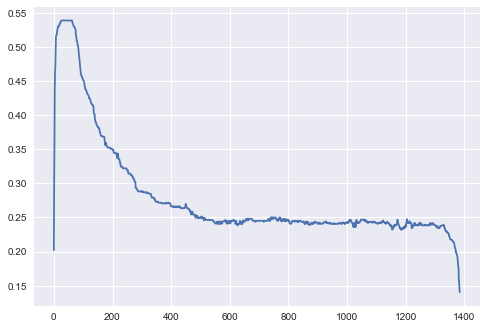

In [42]:
import scipy.signal
import seaborn
import matplotlib.pyplot as plt
neg_LossD = -np.array(LossD, dtype=np.float64)
med_filtered_loss = scipy.signal.medfilt(neg_LossD, 101)

plt.plot(range(len(med_filtered_loss)), med_filtered_loss)
plt.show()

In [92]:
fixed_mask_2 = mask_map(nz, labels=torch.cat([torch.ones(8) * i for i in range(0,8)]))
fixed_mask_2 = fixed_mask_2.cuda()
print(torch.cat([torch.ones(8) * i for i in range(0,7)]).size())

torch.Size([56])


In [93]:
temp= torch.FloatTensor(8, nz).normal_(0,1)
input_z.copy_(torch.cat([temp] * 8))
t = netG(Variable(input_z, volatile=True), Variable(fixed_mask_2, volatile=True))
t.data = t.data.mul(0.5).add(0.5)
vutils.save_image(t.data, '{0}/validate.png'.format(dirname))